In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 3. Логистическая регрессия. Реализация

Функция ошибки для логистической регрессии в случае бинарной классификации называется бинарной кросс-энтропией и записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на оптимизации функции ошибки градиентным спуском.

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку.

In [2]:
adult = pd.read_csv('adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [3]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Описание датасета

with open('adult.names', 'r') as f:
    names = f.read()
print(names)

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [6]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [7]:
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [8]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

In [11]:
adult[adult.salary != 0]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
7,0.983734,0.188195,-0.420060,-0.145920,-0.21666,0.369519,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
8,-0.555830,-1.364279,1.523438,1.761142,-0.21666,0.774468,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
9,0.250608,-0.287350,1.134739,0.555214,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
10,-0.115955,0.859186,-0.031360,-0.145920,-0.21666,3.204161,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
11,-0.629143,-0.459328,1.134739,-0.145920,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,2.376673,0.924634,2.300838,-0.145920,-0.21666,-2.465122,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
32545,0.030671,-0.741645,0.746039,-0.145920,-0.21666,-1.655225,1,0,0,1,...,0,0,1,0,0,0,0,1,1,0
32554,1.057047,1.251432,1.523438,-0.145920,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
32557,0.103983,-0.335433,-0.420060,-0.145920,-0.21666,-0.035429,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [12]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [13]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

In [14]:
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

In [15]:
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [16]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [17]:
theta

array([-3.18220152e+00, -2.97874470e-01,  4.91984312e-01,  2.28275110e-02,
        1.05574662e+00,  3.62299888e-01,  1.61096748e+00,  6.90788800e-01,
       -7.85036544e-01,  8.40399041e-01,  9.09710550e-01, -7.81877921e-02,
       -1.29220590e-02,  2.58558666e-01,  1.02543563e+00,  3.30697269e-01,
        6.46143233e-01,  8.35398252e-01,  9.78308166e-01,  2.36520366e-01,
        9.88443132e-04,  6.18223280e-01,  1.14915955e+00,  1.02420428e+00,
        4.24799786e-01, -1.39716497e+00,  1.59897859e-01,  5.53494533e-01,
        7.79500017e-02,  9.33962074e-01,  8.58881427e-01,  4.35222964e-01,
        6.08930383e-01,  7.68917996e-01,  2.32468515e-01,  9.74747564e-01,
        6.21876481e-01,  8.98087390e-01, -3.15524980e-01,  6.37883564e-01,
       -6.37888463e-01,  4.08394474e-01,  1.08787945e+00,  5.89057982e-01,
        3.24397258e-01,  3.36378365e-01,  3.38583874e-01,  9.64814314e-01,
        3.95775461e-01,  5.20449527e-01,  7.61509306e-01,  9.87311090e-01,
        1.42333149e+00,  

In [18]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [19]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

acc = 0.85 F1-score = 0.65


In [20]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.66


In [21]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

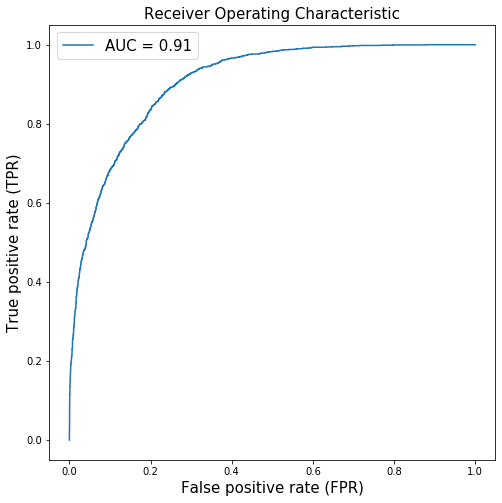

In [22]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
calc_and_plot_roc(y_valid, y_pred_proba)

## 4. Добавление регуляризации

### 4.1. Оборачивание линейной регрессии в класс

In [23]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [24]:
class LinReg(RegOptimizer):
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)

        return grad
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = X.dot(self.theta)
        
        return y_pred

In [25]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [26]:
linreg = LinReg(0.01, 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [27]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 25.11, RMSE = 5.01


### 4.2. Оборачивание логистической регрессии в класс

In [28]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

In [31]:
def prepare_adult_data():
    adult = pd.read_csv('adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [32]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [33]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.65


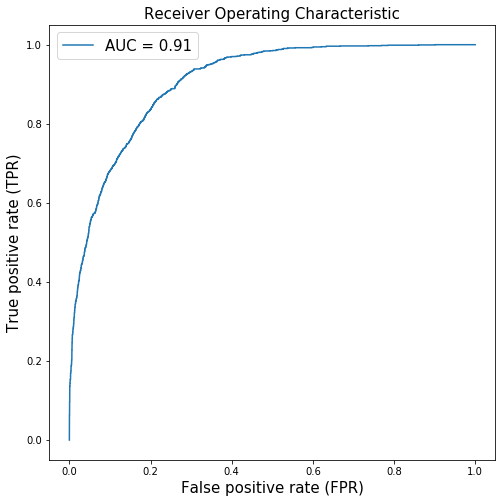

In [34]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

В случаях линейной и логистической регрессии будем добавлять к функции ошибки регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept/bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

### 4.3. Добавление регуляризатора в линейную регрессию

После добавления регуляризации функция ошибки линейной регрессии будет выглядеть следующим образом:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$
А ее градиент по параметру $\theta$:
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [35]:
class LinRegRegularized(LinReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LinRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [36]:
linreg = LinRegRegularized(alpha=0.01, lambd=0.05, n_iters=500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [37]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 16.10, RMSE = 4.01


### 4.4. Добавление регуляризатора в логистическую регрессию

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [38]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [39]:
logreg = LogRegRegularized(alpha=1., lambd=1., n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [40]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.66


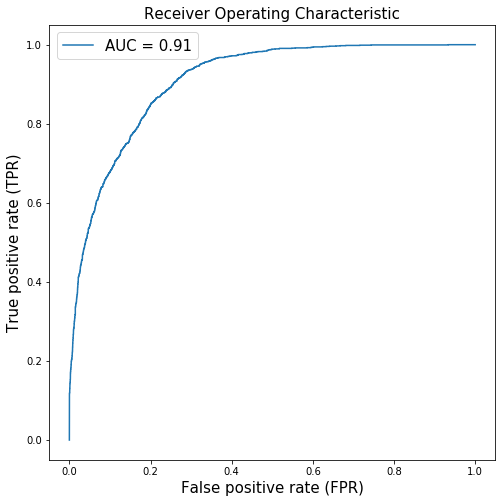

In [41]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)